In [7]:
import pandas as pd
import numpy as np
# Import libraries
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

About Dataset
Digital payments are evolving, but so are cyber criminals.

According to the Data Breach Index, more than 5 million records are being stolen on a daily basis, a concerning statistic that shows - fraud is still very common both for Card-Present and Card-not Present type of payments.

In today’s digital world where trillions of Card transaction happens per day, detection of fraud is challenging.

This Dataset sourced by some unnamed institute.

Feature Explanation:

distance_from_home - the distance from home where the transaction happened.

distance_from_last_transaction - the distance from last transaction happened.

ratio_to_median_purchase_price - Ratio of purchased price transaction to median purchase price.

repeat_retailer - Is the transaction happened from same retailer.

used_chip - Is the transaction through chip (credit card).

used_pin_number - Is the transaction happened by using PIN number.

online_order - Is the transaction an online order.

# fraud - Is the transaction fraudulent.*kalın metin*

In [5]:
df=pd.read_csv("/content/card_transdata.csv")

In [30]:
df.head()
df = df.dropna()


**EDA**

In [8]:
def check_df(dataframe, head=5):
    print("################## Shape ##################")
    print(dataframe.shape)
    print("################## Types ##################")
    print(dataframe.dtypes)
    print("################## Head ##################")
    print(dataframe.head(head))
    print("################## Tail ##################")
    print(dataframe.tail(head))
    print("################## NA ##################")
    print(dataframe.isnull().sum())
    print("################## Quantiles ##################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

################## Shape ##################
(68734, 8)
################## Types ##################
distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object
################## Head ##################
   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219  

**VARİABLES**

In [9]:
target = "fraud"
num_cols = [col for col in df.columns if df[col].dtype != "O" and df[col].nunique() > 10]
cat_cols = [col for col in df.columns if df[col].dtype == "O" and df[col].nunique() < 20]
cat_but_car = [col for col in df.columns if df[col].dtype == "O" and df[col].nunique() > 20]
num_but_cat = [col for col in df.columns if df[col].dtype != "O" and df[col].nunique() < 5]

cat_cols = num_but_cat + cat_cols
cat_cols.remove(target)
print(f"Categorical columns: {len(cat_cols)}")
print(cat_cols)
print("\n")
print(f"Numerical columns: {len(num_cols)}")
print(num_cols)
print("\n")
print(f"Categorical but high cardinality columns: {len(cat_but_car)}")
print(cat_but_car)
print("\n")
print(f"Numerical but categorical columns: {len(num_but_cat)}")
print(num_but_cat)



Categorical columns: 4
['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']


Numerical columns: 3
['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']


Categorical but high cardinality columns: 0
[]


Numerical but categorical columns: 5
['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']


**NUMERİCAL ANALYSİS**

In [10]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
df.describe(quantiles).T

,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
distance_from_home,68734.0,26.706679,65.892309,0.021322,1.028104,1.692003,3.090702,4.828513,7.041233,9.997489,14.246444,20.943309,32.561595,60.057328,99.963217,264.354388,4601.011222
distance_from_last_transaction,68734.0,5.115756,26.340940,0.000488,0.051969,0.100040,0.220520,0.386663,0.626870,0.989598,1.553232,2.540236,4.479659,9.955346,19.106664,64.876961,2160.499922
ratio_to_median_purchase_price,68733.0,1.805618,2.762802,0.011373,0.163302,0.242413,0.395604,0.562647,0.756499,0.994685,1.314433,1.763993,2.485042,4.028372,5.978959,12.688502,124.417850
repeat_retailer,68733.0,0.883899,0.320349,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
used_chip,68733.0,0.351869,0.477557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
used_pin_number,68733.0,0.103167,0.304180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
online_order,68733.0,0.650648,0.476769,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
fraud,68733.0,0.085999,0.280365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000


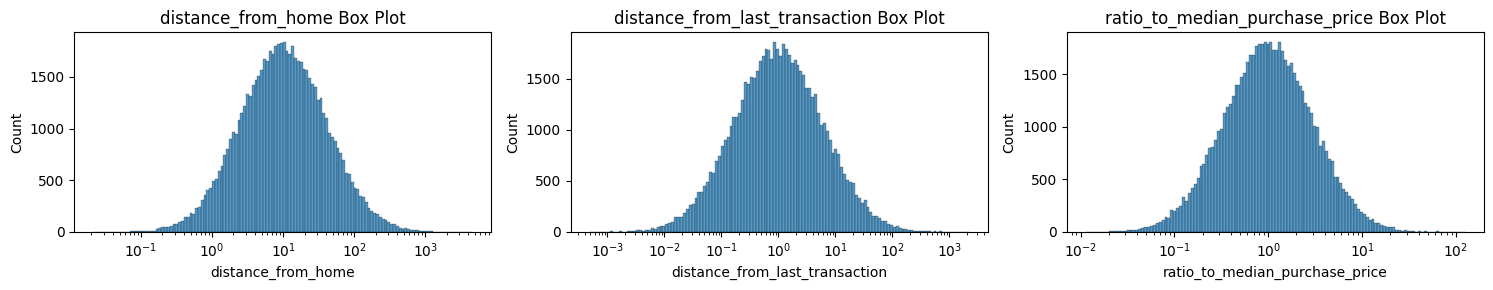

In [11]:
# Distribution of Numericals
n_cols = 4
n_rows = len(num_cols) // n_cols + (1 if len(num_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))

for i, column in enumerate(num_cols):
    row_index = i // n_cols
    col_index = i % n_cols

    sns.histplot(x=df[column], ax=axs[col_index], log_scale=True)
    axs[col_index].set_title(f"{column} Box Plot")


for i in range(len(num_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

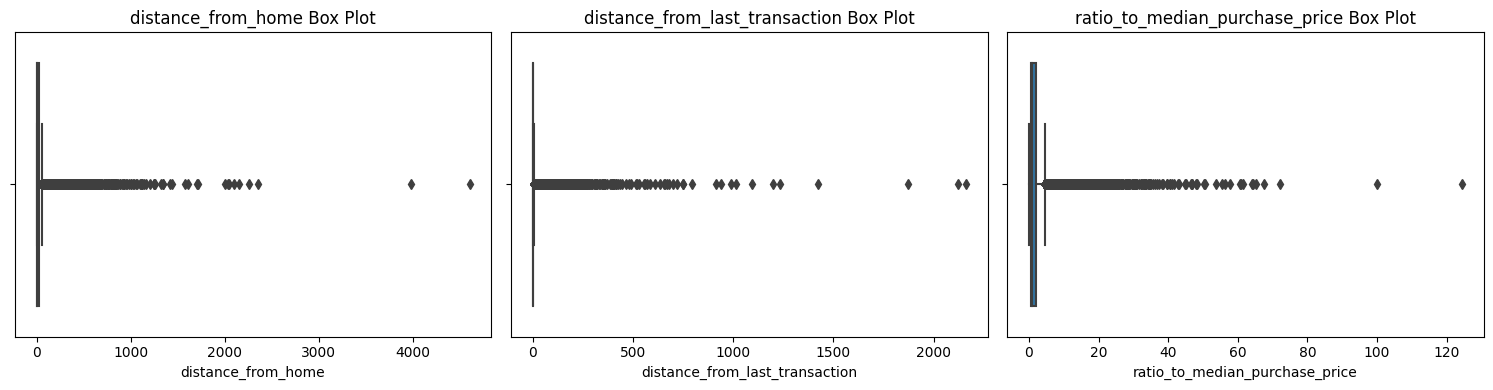

In [12]:
# Box plot of Numericals
n_cols = 4
n_rows = len(num_cols) // n_cols + (1 if len(num_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

for i, column in enumerate(num_cols):
    row_index = i // n_cols
    col_index = i % n_cols

    sns.boxplot(x=df[column], ax=axs[col_index])
    axs[col_index].set_title(f"{column} Box Plot")


for i in range(len(num_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

**CATEGORİCAL ANALYSİS**

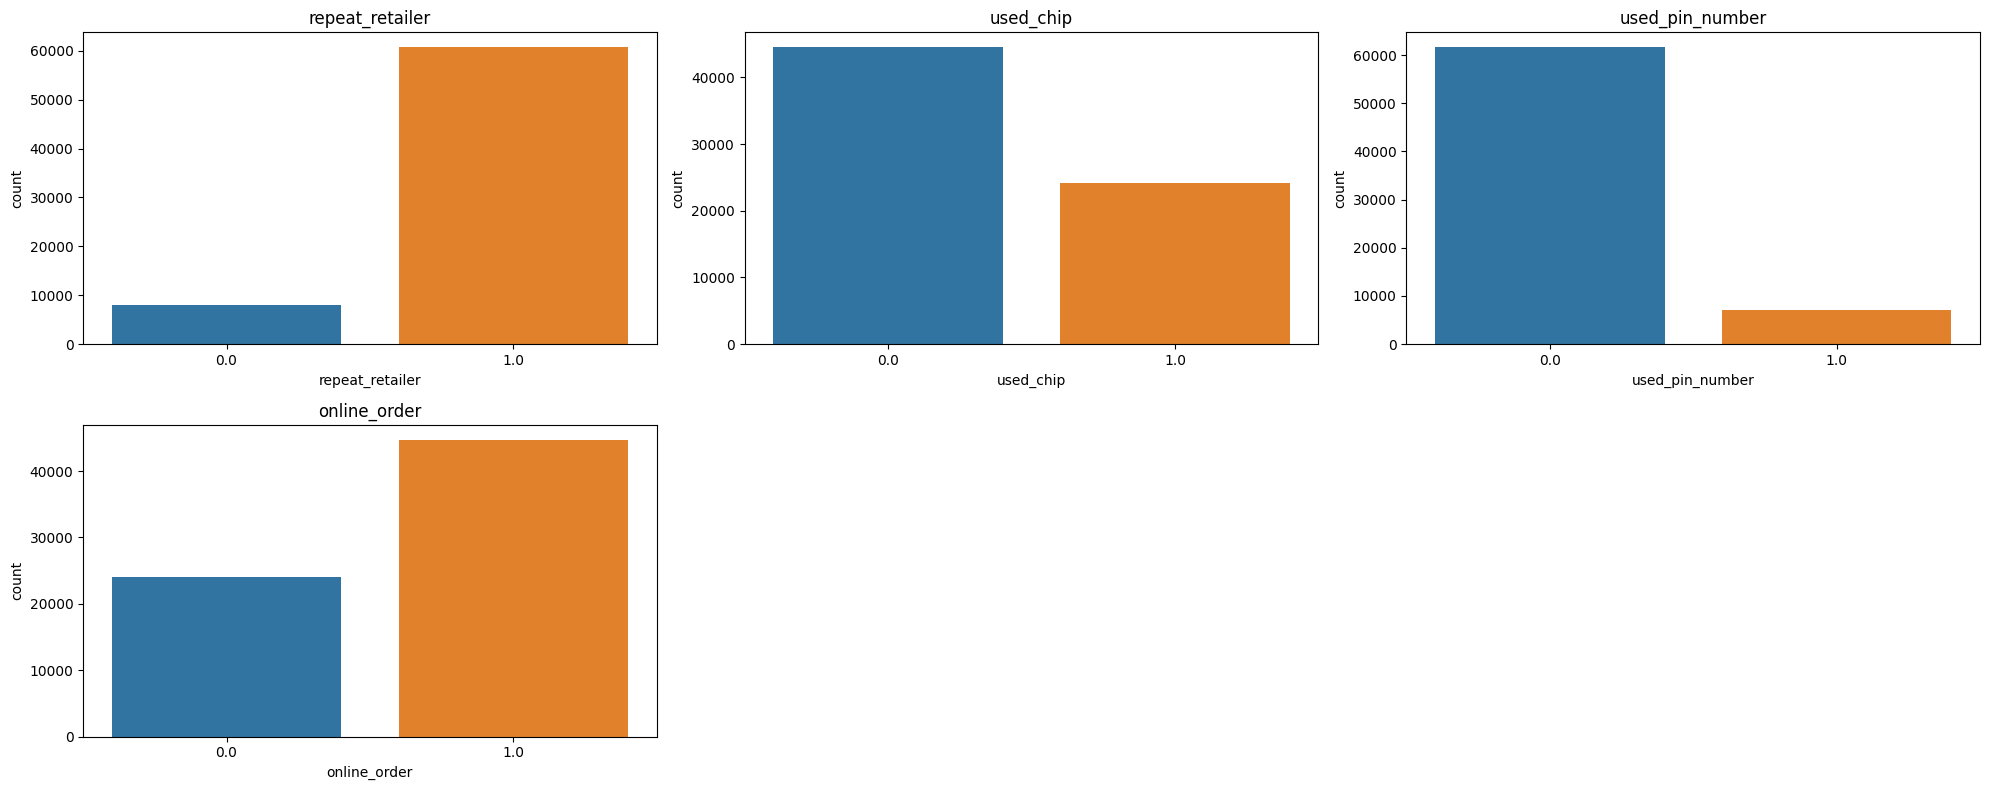

In [13]:
# Countplot of categorical variables
n_cols = 3
n_rows = len(cat_cols) // n_cols + (1 if len(cat_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

for i, column in enumerate(cat_cols):
    row_index = i // n_cols
    col_index = i % n_cols

    sns.countplot(x=df[column], ax=axs[row_index, col_index])
    axs[row_index, col_index].set_title(f"{column}")


for i in range(len(cat_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

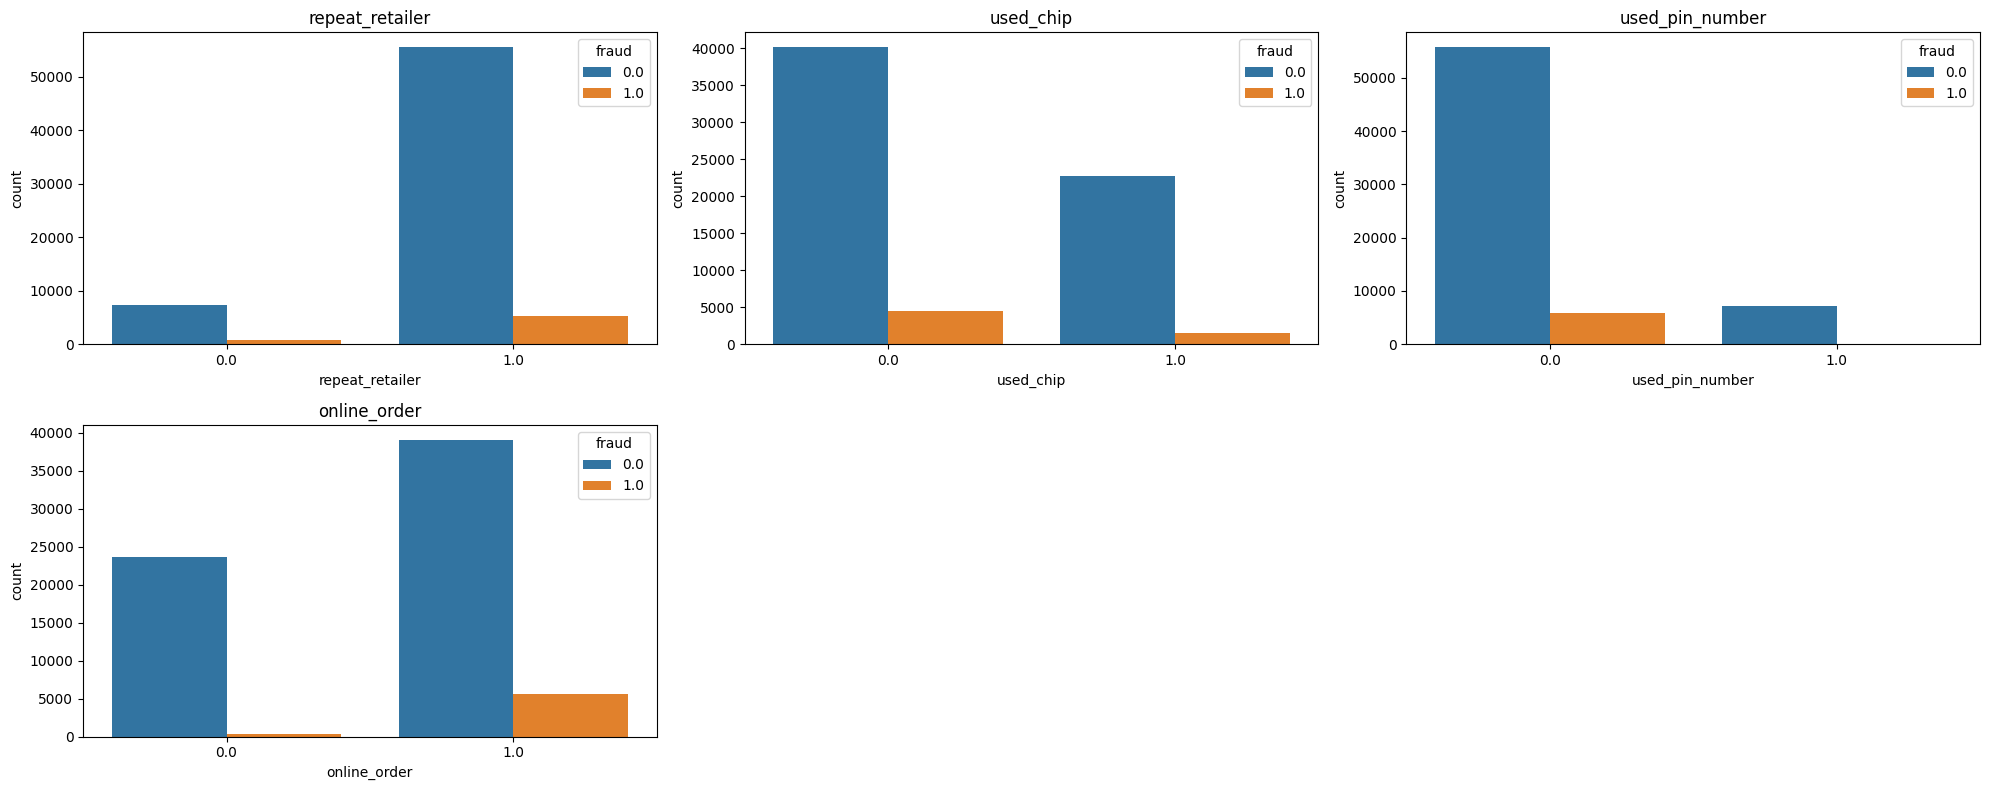

In [14]:
# How categorical variables effects on Fraud
n_cols = 3
n_rows = len(cat_cols) // n_cols + (1 if len(cat_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

for i, column in enumerate(cat_cols):
    row_index = i // n_cols
    col_index = i % n_cols

    sns.countplot(x=df[column], ax=axs[row_index, col_index], hue=df["fraud"])
    axs[row_index, col_index].set_title(f"{column}")


for i in range(len(cat_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

In [15]:
def cat_summary(dataframe, col_name, plot=False):
    val_count = dataframe[col_name].value_counts()
    per = (val_count * 100) / len(dataframe)
    print(pd.DataFrame({col_name: val_count, "Ratio": per}))
    print("######################################")
for col in cat_cols:
    cat_summary(df, col)

     repeat_retailer      Ratio
1.0            60753  88.388570
0.0             7980  11.609975
######################################
     used_chip      Ratio
0.0      44548  64.812174
1.0      24185  35.186371
######################################
     used_pin_number      Ratio
0.0            61642  89.681962
1.0             7091  10.316583
######################################
     online_order      Ratio
1.0         44721  65.063869
0.0         24012  34.934676
######################################


**TARGET ANLAYSİS**

In [16]:
df[target].value_counts() * 100 / df.shape[0]

0.0    91.398726
1.0     8.599820
Name: fraud, dtype: float64

**91.25% of the data are normal transactions, but 8.74% are fraudulent transactions, so the dataset has a high imbalance.**

<Axes: xlabel='fraud', ylabel='count'>

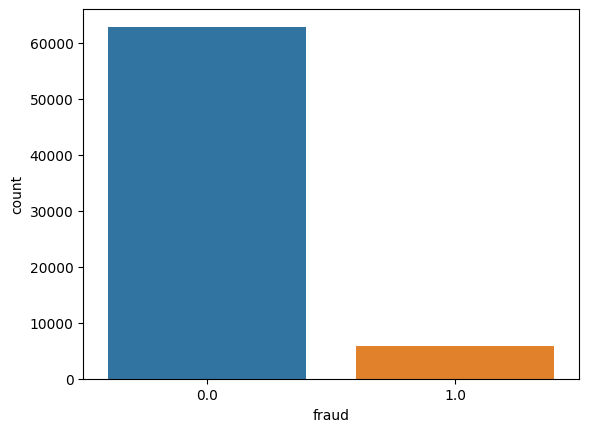

In [17]:
sns.countplot(x = df[target])

In [18]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}))

for col in cat_cols:
    target_summary_with_cat(df, target, col)

                 TARGET_MEAN
repeat_retailer             
0.0                 0.087093
1.0                 0.085856
           TARGET_MEAN
used_chip             
0.0           0.099107
1.0           0.061857
                 TARGET_MEAN
used_pin_number             
0.0                 0.095536
1.0                 0.003103
              TARGET_MEAN
online_order             
0.0              0.012535
1.0              0.125444


In [19]:
df.groupby(target)[num_cols].mean()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
fraud,,,
0.0,23.022130,4.333240,1.417809
1.0,65.870209,13.433089,5.927245


**CORELATİON ANALYSİS**

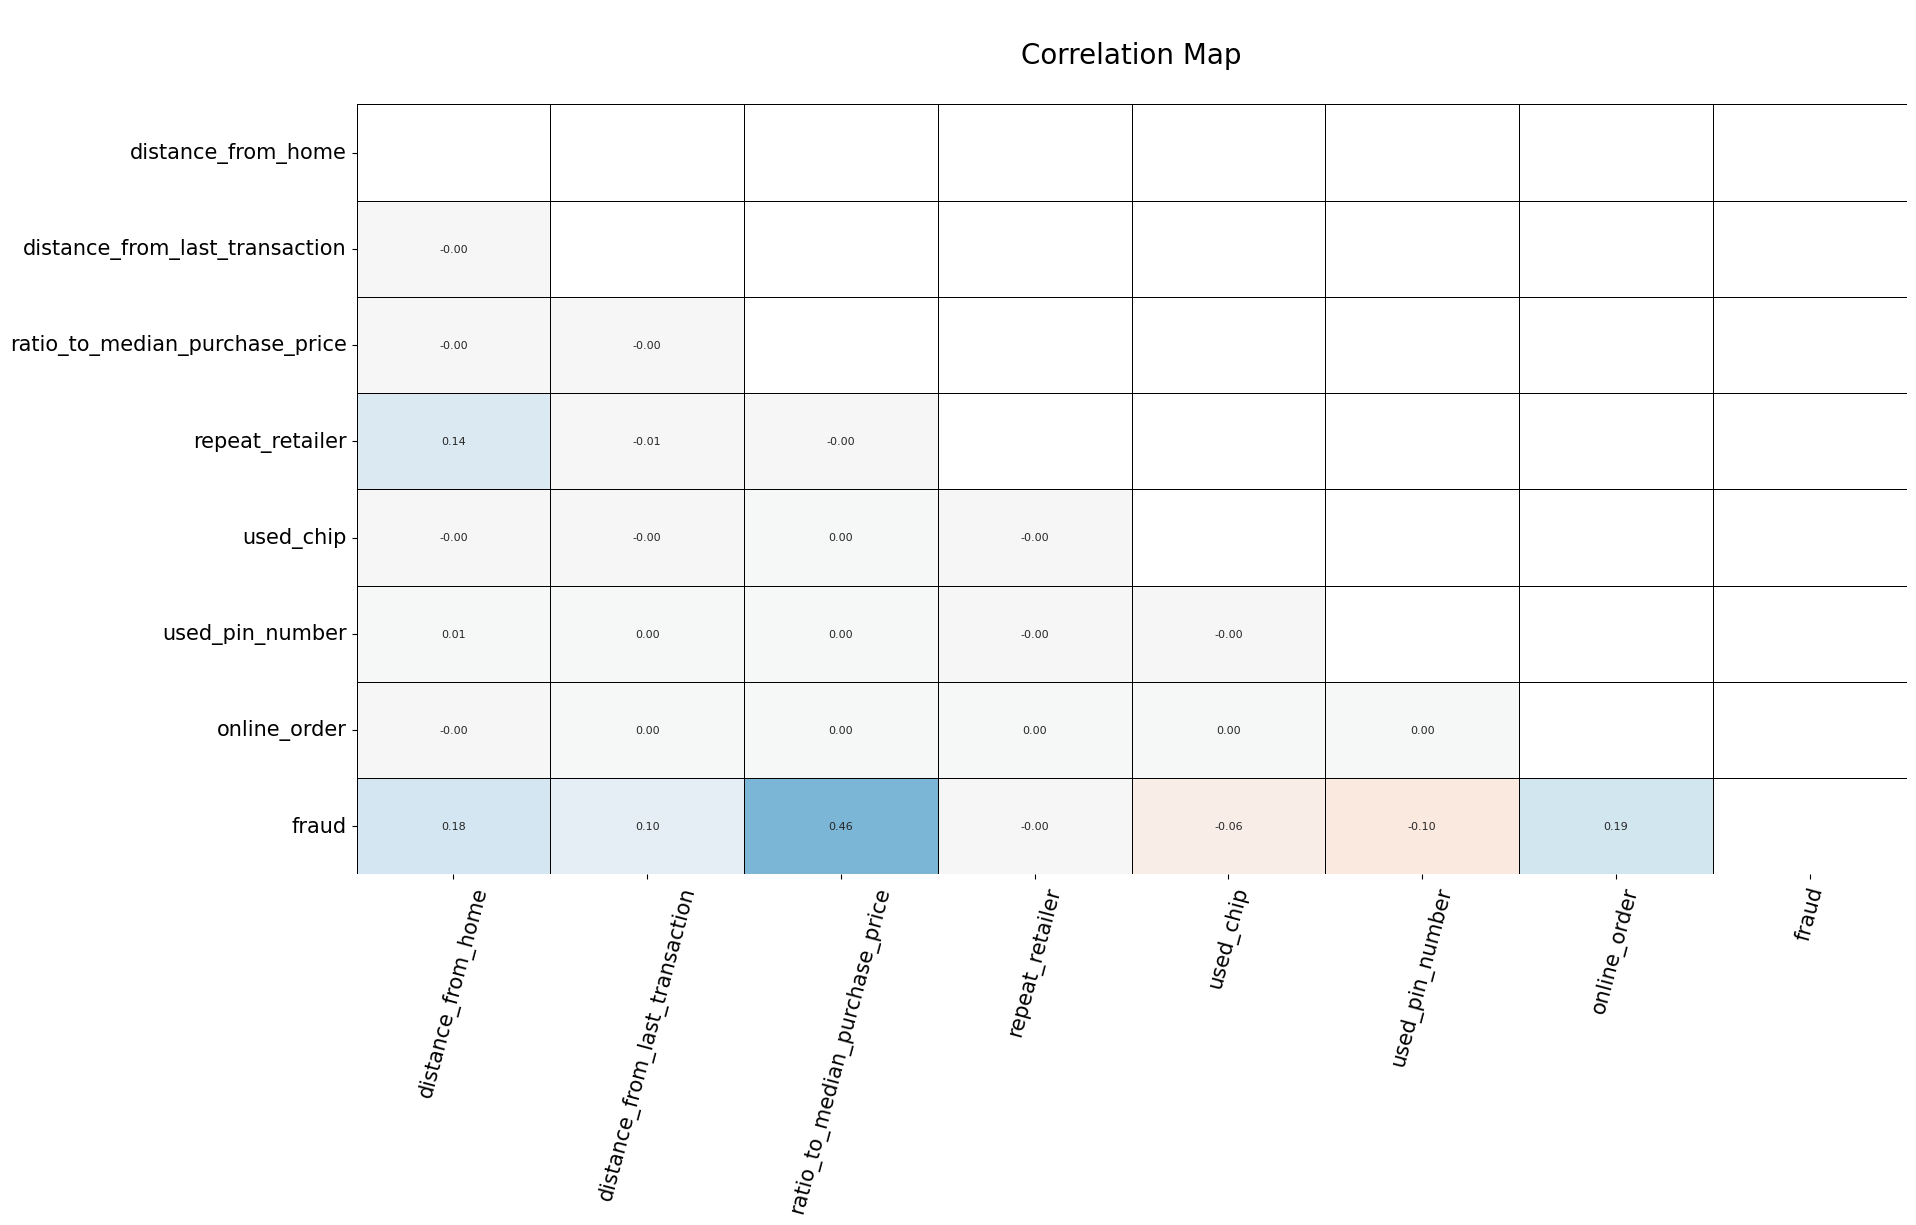

In [20]:
def corr_map(df, width=14, height=6, annot_kws=15):
    mtx = np.triu(df.corr())
    f, ax = plt.subplots(figsize = (width,height))
    sns.heatmap(df.corr(),
                annot= True,
                fmt = ".2f",
                ax=ax,
                vmin = -1,
                vmax = 1,
                cmap = "RdBu",
                mask = mtx,
                linewidth = 0.4,
                linecolor = "black",
                cbar=False,
                annot_kws={"size": annot_kws})
    plt.yticks(rotation=0,size=15)
    plt.xticks(rotation=75,size=15)
    plt.title('\nCorrelation Map\n', size = 20)
    plt.show();

corr_map(df, width=20, height=10, annot_kws=8)

**DATA PREPROCESSİNG**

In [21]:
# Outlier functions

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [22]:
print("Is there any outlier value in Numericals?".upper())
for col in num_cols:
    print(col, check_outlier(df, col))

IS THERE ANY OUTLIER VALUE IN NUMERICALS?
distance_from_home True
distance_from_last_transaction True
ratio_to_median_purchase_price True


In [23]:
# Re-assignment with thresholds
for col in num_cols:
    replace_with_thresholds(df, col)

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,68734.0,24.460953,40.454190,0.021322,3.902017,9.997489,25.857504,248.365886
distance_from_last_transaction,68734.0,3.928203,8.181823,0.000488,0.296104,0.989598,3.330132,47.688707
ratio_to_median_purchase_price,68733.0,1.750877,2.224730,0.011373,0.474930,0.994685,2.078707,14.702445
repeat_retailer,68733.0,0.883899,0.320349,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,68733.0,0.351869,0.477557,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,68733.0,0.103167,0.304180,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,68733.0,0.650648,0.476769,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,68733.0,0.085999,0.280365,0.000000,0.000000,0.000000,0.000000,1.000000


In [25]:
# Scaling

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [26]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.826049,-0.442088,0.087680,1.0,1.0,0.0,0.0,0.0
1,-0.336952,-0.458656,-0.205266,1.0,0.0,0.0,0.0,0.0
2,-0.478814,-0.381709,-0.594756,1.0,0.0,0.0,1.0,0.0
3,-0.549104,0.204337,-0.623997,1.0,1.0,0.0,1.0,0.0
4,0.487715,-0.410879,0.212113,1.0,1.0,0.0,1.0,0.0


**BASE MODEL**

In [31]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=17)

clf = LogisticRegression().fit(X_train, y_train)

In [32]:
y_pred = clf.predict(X_test)


**BASE MODEL VALİDATİON**

In [33]:
#Checking if the model is overfit or underfit

# f1_score on train data
X_train_pred = clf.predict(X_train)
train_data_f1 = f1_score(X_train_pred, y_train)
print("Train f1 Score: ", train_data_f1)

# f1_score on test data
train_data_f1 = f1_score(y_pred, y_test)
print("Test f1 Score: ", train_data_f1)

Train f1 Score:  0.7504108945761915
Test f1 Score:  0.7374461979913917


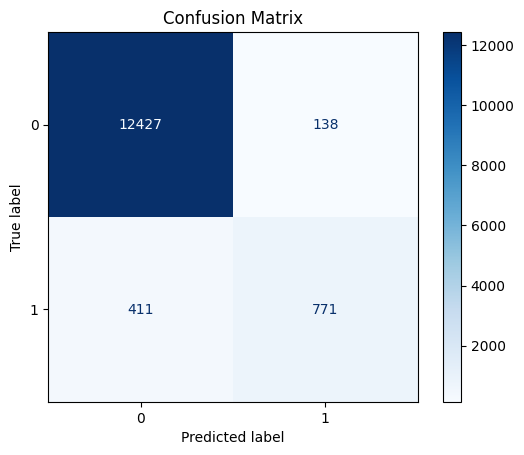

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     12565
         1.0       0.85      0.65      0.74      1182

    accuracy                           0.96     13747
   macro avg       0.91      0.82      0.86     13747
weighted avg       0.96      0.96      0.96     13747



In [34]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [35]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

cv_results = cross_validate(clf,
                            X_train, y_train,
                            cv=kf,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Accuracy: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("Recall: ",cv_results['test_recall'].mean())
print("Roc_Auc: ",cv_results['test_roc_auc'].mean())

Accuracy:  0.9611719710030855
F1:  0.7488822557937547
Recall:  0.6737129881315929
Roc_Auc:  0.9748197225106388


In [36]:
y_pred_prob_clf = clf.predict_proba(X_test)[:,1]
auc_clf = roc_auc_score(y_test, y_pred_prob_clf)

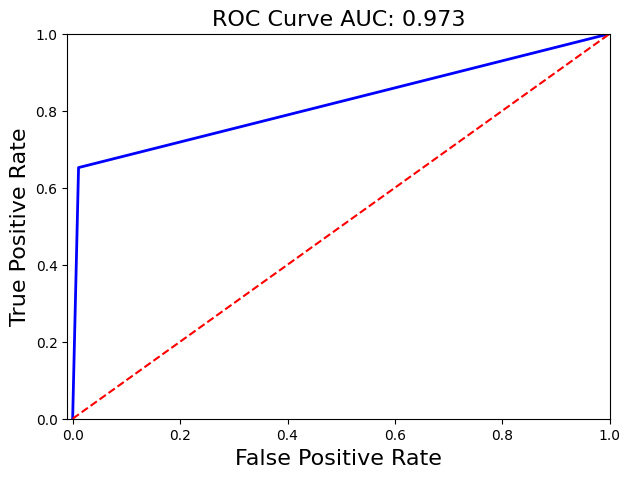

In [37]:
fpr, tpr, thresold = roc_curve(y_test, y_pred)

def roc_curve_graph(fpr, tpr):
    plt.figure(figsize=(7,5))
    plt.title(f'ROC Curve AUC: {round(auc_clf, 3)}', fontsize=16)
    plt.plot(fpr, tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

roc_curve_graph(fpr, tpr)
plt.show()

**Model with SMOTE Oversampling**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=17)

oversample = SMOTE(sampling_strategy = 'minority', random_state=17)

X_smote, y_smote = oversample.fit_resample(X_train, y_train)

print("y_train shape", y_train.shape)
print("y_smote shape", y_smote.shape)

y_train shape (54986,)
y_smote shape (100514,)


In [39]:
clf_os = LogisticRegression().fit(X_smote, y_smote)

In [40]:
y_pred_os = clf_os.predict(X_test)


**Validation**

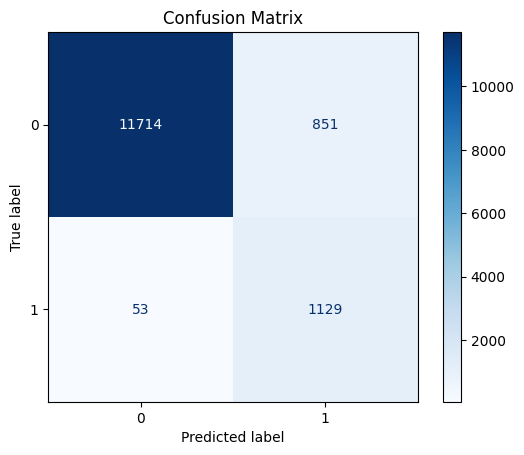

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     12565
         1.0       0.57      0.96      0.71      1182

    accuracy                           0.93     13747
   macro avg       0.78      0.94      0.84     13747
weighted avg       0.96      0.93      0.94     13747



In [41]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(y_test, y_pred_os)
print(classification_report(y_test, y_pred_os))

In [42]:
y_pred_prob_os = clf_os.predict_proba(X_test)[:,1]
auc_os = roc_auc_score(y_test, y_pred_prob_os)

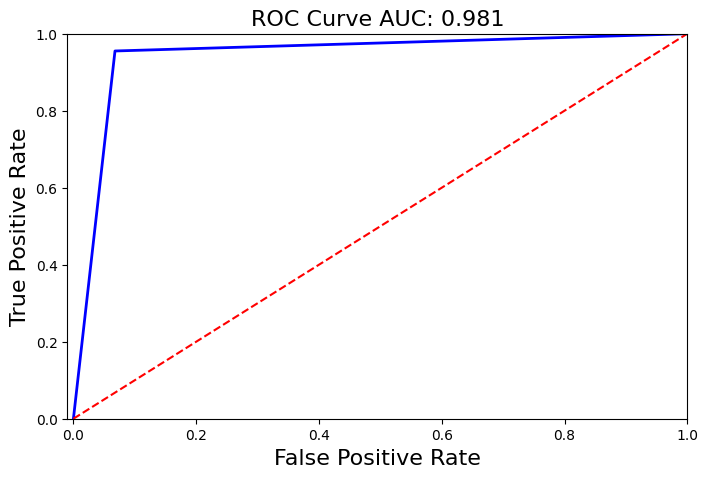

In [43]:
fpr, tpr, thresold = roc_curve(y_test, y_pred_os)

def roc_curve_graph(fpr, tpr):
    plt.figure(figsize=(8,5))
    plt.title(f'ROC Curve AUC: {round(auc_os, 3)}', fontsize=16)
    plt.plot(fpr, tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

roc_curve_graph(fpr, tpr)
plt.show()

In [44]:
cv_results = cross_validate(clf_os,
                            X, y,
                            cv=kf,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Accuracy: ",cv_results['test_accuracy'].mean())
print("F1: ",cv_results['test_f1'].mean())
print("Recall: ",cv_results['test_recall'].mean())
print("Roc_Auc: ",cv_results['test_roc_auc'].mean())

Accuracy:  0.9611831640083984
F1:  0.7486154635022889
Recall:  0.6719689395597245
Roc_Auc:  0.9739807219243396


**Model with Undersampling Tomek**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=15)

tomek = TomekLinks(sampling_strategy="majority")

X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

clf_tomek = LogisticRegression().fit(X_tomek, y_tomek)

In [46]:
print("X shape: ", X_tomek.shape)
print("y shape: ", y_tomek.shape)

X shape:  (54928, 7)
y shape:  (54928,)


**Validation**

In [47]:
#Checking if the model is overfit or underfit

# recall on train data
X_train_pred = clf_tomek.predict(X_tomek)
train_data_recall = recall_score(y_tomek, X_train_pred)
print("Train Recall: ", train_data_recall)

# recall on test data
y_pred = clf_tomek.predict(X_test)
test_data_recall = recall_score(y_test, y_pred)
print("Test Recall: ", test_data_recall)

Train Recall:  0.676252907591457
Test Recall:  0.682741116751269


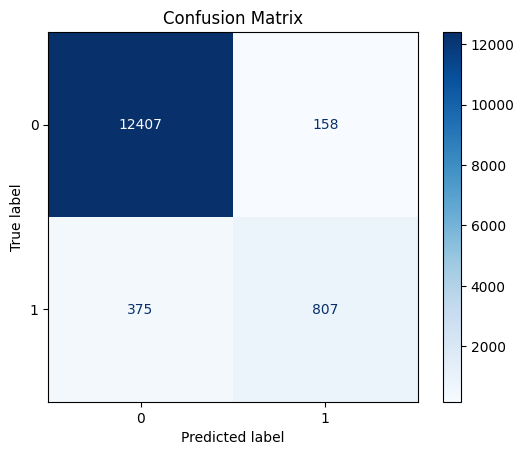

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     12565
         1.0       0.84      0.68      0.75      1182

    accuracy                           0.96     13747
   macro avg       0.90      0.84      0.87     13747
weighted avg       0.96      0.96      0.96     13747



In [48]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [49]:
y_pred_prob_tomek = clf_tomek.predict_proba(X_test)[:,1]
auc_score_tomek = roc_auc_score(y_test, y_pred_prob_tomek)

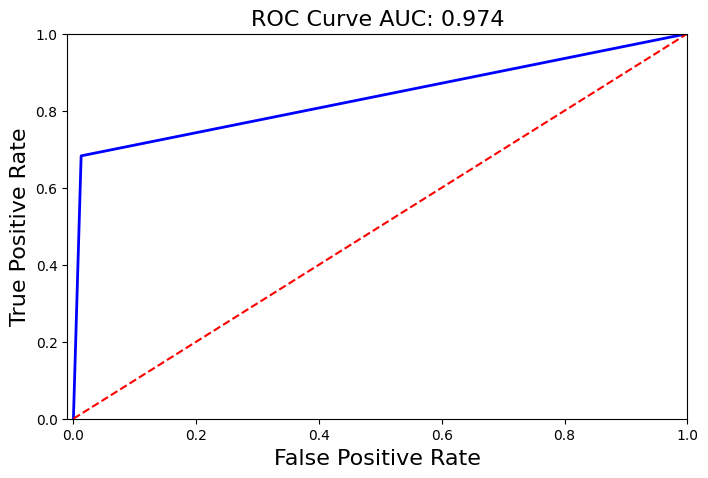

In [50]:
fpr, tpr, thresold = roc_curve(y_test, y_pred)

def roc_curve_graph(fpr, tpr):
    plt.figure(figsize=(8,5))
    plt.title(f'ROC Curve AUC: {round(auc_score_tomek, 3)}', fontsize=16)
    plt.plot(fpr, tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

roc_curve_graph(fpr, tpr)
plt.show()

**Result


*The best result is oversampled LogisticRegression used SMOTE method with 0.981 AUC Score, 0.96 Recall.
*Undersampled LogisticRegression used TOMEK has 0.974 AUC Score, 0.69 Recall.
*Base LogisticRegression model has 0.974 AUC Score, 0.68 Recall.